<center>
<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
</center>
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Week 12 Tutorial: Logistic Regression from Scratch</h2>
<br>

In this tutorial, we'll use our knowledge of maximum likelihood and optimisation methods to code an implementation of the logistic regression algorithm using general Python libraries. 

As we've seen throughout the unit, you don't need to understand the technical details behind most machine learning methods to be able to use them in applications. However, if you want to take your skills to the next level and develop deep understanding, then implementing methods is one the best things that you can do.

In [1]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

# 1. Stepping Stone: Bernoulli Model

To train a logistic regression method, we need to use algorithms such as Newton's method and gradient descent for optimisation. However, instead of jumping straight to this relatively complex task, it's useful to start with a simple special case to build understanding and test the code. 

We consider the model $Y_1,Y_2,\ldots,Y_n\sim \operatorname{Bernoulli}\Big(\sigma(\beta)\Big)$, where $\beta\in \mathbb{R}$ is a parameter and $\sigma$ is the sigmoid function
\begin{equation}
\sigma(\beta)=\frac{1}{1+\exp(-\beta)},
\end{equation}
as in the previous tutorial.

Below, we will also refer to the probability $\pi=\sigma(\beta)$, which is easier to interpret.

## 1.1 Simulated data

The next cell generates some data from the model.

In [3]:
from scipy import stats

np.random.seed(10) # setting the random seed ensures that we get the same sample if we run the code again
prob = 0.7 # true value of the probability parameter pi
y = stats.bernoulli.rvs(prob, size=1000) 

Last week, we derived that the MLE of $\beta$ is $\widehat{\beta}=\sigma^{-1}(\overline{y})$ and that the MLE of $\pi$ is the sample proportion $\overline{y}$. 

We can then compare the results from numerical optimisation to the exact solution.

In [4]:
from scipy.special import logit, expit # expit is the logistic function

print(f'The maximum likelihood estimate of beta is {logit(np.mean(y)):.3f} \n')
print(f'The maximum likelihood estimate of pi is {np.mean(y)}')

The maximum likelihood estimate of beta is 0.824 

The maximum likelihood estimate of pi is 0.695


## 1.2 Cost function and derivatives

Last week, we derived the following cost function for this estimating this model:
\begin{equation}
J(\beta)=\frac{1}{n}\sum_{i=1}^n \left(-y_i\log\Big(\sigma(\beta)\Big)-(1-y_i)\log\Big(1-\sigma(\beta)\Big)\right).
\end{equation}

Dividing by $n$ is useful in practice for stability.

We can implement the above equation directly or use the following simplification: 
\begin{equation}
J(\beta)=\log\Big(1+\exp(\beta)\Big)-\overline{y}\beta.
\end{equation}

It's a good exercise to show  (in your own time) that this second expression is equivalent to the first . The function $\zeta(x)=\log\Big(1+\exp(x)\Big)$ is known as the softplus function.

While the computational cost is not an issue here, it's often useful to try to reduce the number of operations when working with more complex methods and large datasets.

Below, we code a function to compute the cost function.

In [5]:
def cost(beta, y):
    return np.log(1+np.exp(beta))-np.mean(y)*beta

We also derived the following formulas for the first and second derivatives:

\begin{equation}
J'(\beta)=\sigma(\beta)-\overline{y}
\end{equation}

\begin{equation}
J''(\beta)=\sigma(\beta)\Big(1-\sigma(\beta)\Big)
\end{equation}

Now, the implementation.

In [6]:
def gradient(beta, y):
    pi = expit(beta) 
    return pi-np.mean(y)

def hessian(beta, y):
    pi = expit(beta)
    return pi*(1-pi)

## 1.3 Newton's method

From the lecture, Newton's method repeats the following update until convergence:

\begin{equation}
\theta^{(k+1)} \leftarrow \theta^{(k)}-\frac{J'(\theta^{(k)})}{J''(\theta^{(k)})}
\end{equation}

Two practical implementation details are the starting value $\theta^{(0)}$ and the convergence criterion.

In [7]:
def newton(x0, y, grad, hess, tol = 1e-6):

    '''
    Newton's method for a single parameter problem

        Parameters:

        x0 : initial guess
        y : sample
        grad : first derivative of the objective function
        hess : second derivative of the objective
        tol : tolerance 

        Returns: 

        x: solution
        history: the design point at every iteration

    '''
    
    x = x0 # starting value
    history = [x]
    iterate = True
    
    while iterate:
        
        x0 = x  # current design point
        x = x0 - grad(x0, y)/hess(x0, y) # updated design point
        history.append(x) # saving the updated design point
        
        # Convergence criterion
        iterate = np.abs(x-x0) > tol 
  
    return x, history

The method converges in four iterations and recovers the correct estimate (up to a small approximation error).

In [8]:
beta, history = newton(0, y, gradient, hessian) # the starting value is beta = 0, which corresponds to pi = 0.5

print(f'Newton\'s method converged in {len(history)-1} iterations \n')
print(f'The solution for beta  {beta:.3f} \n')
print(f'The solution for pi is {expit(beta):.3f}')

Newton's method converged in 4 iterations 

The solution for beta  0.824 

The solution for pi is 0.695


The next figure shows the solution's trajectory. The blue curve plots the cost function, while the ticks indicate the design point and the value of the cost function at every iteration. 

We can see that Newton's method jumps close to the global minimum in one iteration. The last update is so small that it's no visible in the plot.

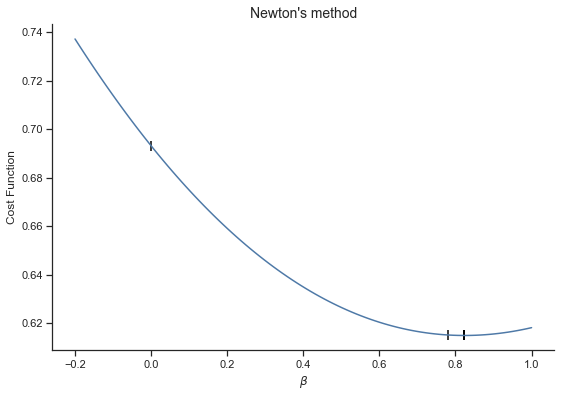

In [9]:
# this code is just for running

betas = np.linspace(-0.2, 1, 100) # grid of values for beta

fig, ax = plt.subplots()


ax.plot(betas, [cost(x, y) for x in betas]) # the list comprehension [] gives the cost function for each beta
ax.scatter(history, [cost(x, y) for x in history], color = 'black', marker = '|', s=100)

ax.set_xlabel(r'$\beta$')
ax.set_ylabel('Cost Function')
ax.set_title('Newton\'s method', fontsize=14)
sns.despine()
plt.show()

## 1.5 Gradient descent

Gradient descent updates the parameter according to:

\begin{equation}
\theta^{(k+1)} \leftarrow \theta^{(k)}-\alpha^{(k)} J'(\theta^{(k)})
\end{equation}

The next cell implements gradient descent with a fixed learning rate.

In [10]:
def gradientdescent(x0, y, grad, alpha = 1, tol = 1e-6):
    
    x = x0
    history = [x]
    
    iterate = True
    while iterate:        
        
        x0 = x
        x = x0 - alpha*grad(x0, y)
        history.append(x)
        
        # Convergence criterion
        iterate = np.abs(x-x0) > tol
    
    return x, history

Let's try it with a learning rate of $\alpha=0.1$.

In [11]:
beta, history = gradientdescent(0, y, gradient, alpha=0.1)

print(f'Gradient descent converged in {len(history)-1} iterations \n')
print(f'The solution for beta  {beta:.3f} \n')
print(f'The solution for pi is {expit(beta):.3f}')

Gradient descent converged in 451 iterations 

The solution for beta  0.824 

The solution for pi is 0.695


Correct answer but terrible convergence! This learning rate is too low. Let's visualise the method's performance.

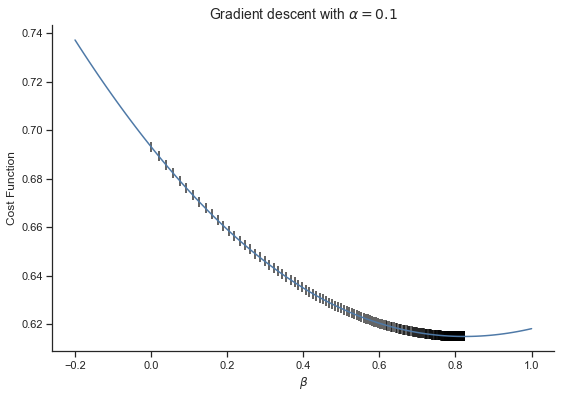

In [12]:
# this code is just for running

betas = np.linspace(-0.2, 1, 100) # grid of values for beta

fig, ax = plt.subplots()


ax.plot(betas, [cost(x, y) for x in betas]) # the list comprehension [] returns the cost function for each beta
ax.scatter(history, [cost(x, y) for x in history], color = 'black', marker = '|', s = 100, alpha = 0.8)

ax.set_xlabel(r'$\beta$')
ax.set_ylabel('Cost Function')
ax.set_title(r'Gradient descent with $\alpha=0.1$', fontsize=14)
sns.despine()
plt.show()

Based on this, we increase the learning rate to $\alpha=1$.

In [13]:
beta, history = gradientdescent(0, y, gradient, alpha = 1)

print(f'Gradient descent converged in {len(history)-1} iterations \n')
print(f'The solution for beta  {beta:.3f} \n')
print(f'The solution for pi is {expit(beta):.3f}')

Gradient descent converged after 51 iterations 

The solution for beta  0.824 

The solution for pi is 0.695


That's better, but still much worse than Newton's method. The plot below shows that the method gets close to the global minimum in about 10 iterations, but needs many additional iterations to refine the solution. That's because the derivative is very close to zero near the local minimum. 

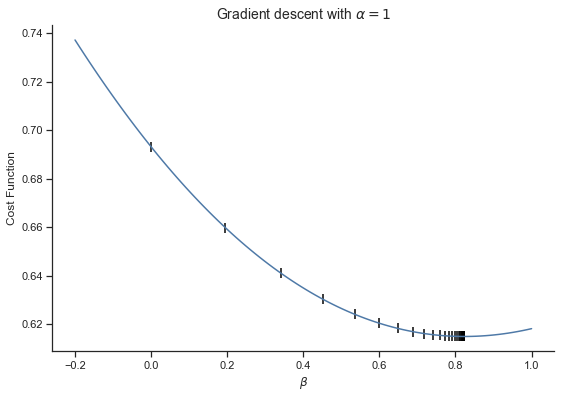

In [14]:
# this code is just for running

betas = np.linspace(-0.2, 1, 100) # grid of values for beta

fig, ax = plt.subplots()

ax.plot(betas, [cost(x, y) for x in betas]) # the list comprehension [] returns the cost function for each beta
ax.scatter(history, [cost(x, y) for x in history], color = 'black', marker = '|', s = 100)

ax.set_xlabel(r'$\beta$')
ax.set_ylabel('Cost Function')
ax.set_title(r'Gradient descent with $\alpha=1$', fontsize=14)
sns.despine()
plt.show()

# 2. Logistic regression

We now continue with our main goal of implementing a logistic regression.

## 2.1 Data and benchmark

We'll use a customer acquisition dataset to test the code. It's a subset of the data used in the GAM tutorial.

In [15]:
data = pd.read_csv('Data\Acquisition.csv', index_col=0)
data.head()

,Acquisition,Acq_Expense,Industry,Revenue,Employees
Customer,,,,,
1,1,760.36,1,30.16,1240
2,0,147.70,1,39.80,166
3,0,252.56,1,54.93,1016
4,1,609.73,1,45.83,122
5,1,672.36,1,69.03,313


We use the `statsmodels` package to fit the model for comparison because it generates a more informative output than scikit-learn.

In [16]:
# this code is just for running

import statsmodels.api as sm

y_train= data['Acquisition']
X_train= sm.add_constant(data.iloc[:, 1:]) # need to manually add a column of ones with statsmodels

feature_names = X_train.columns

sm_logit = sm.Logit(y_train, X_train).fit()

print(sm_logit.summary())

Optimization terminated successfully.
         Current function value: 0.217643
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:            Acquisition   No. Observations:                  500
Model:                          Logit   Df Residuals:                      495
Method:                           MLE   Df Model:                            4
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:                  0.6795
Time:                        14:05:58   Log-Likelihood:                -108.82
converged:                       True   LL-Null:                       -339.48
Covariance Type:            nonrobust   LLR p-value:                 1.546e-98
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -13.5205      1.497     -9.033      0.000     -16.454     -10.587
Acq_Expense     0.0215    

## 2.2 Newton's method

The general update for Newton's method is:

\begin{equation}
\mathbf{\theta}^{(k+1)} = \mathbf{\theta}^{(k)}-\left(\nabla^2 J(\mathbf{\theta}^{(k)})\right)^{-1}\nabla J(\mathbf{\theta}^{(k)})
\end{equation}

In the lecture, we derived:

\begin{equation}
\frac{\partial J}{\partial \beta_k}=n^{-1}\sum_{i=1}^{n}x_{ik}\left(\pi_i-y_i\right).
\end{equation}

Define the following vector:
\begin{equation}
{\boldsymbol \pi} = (\pi_1,\ldots,\pi_n)
\end{equation}

Then, it follows from definition of matrix multiplication (optional exercise) that we can write the gradient as
\begin{equation}
\nabla J(\beta) =n^{-1} {\boldsymbol X}^\top ({\boldsymbol \pi} - {\boldsymbol y}).
\end{equation}

From the partial derivative, we can also obtain (optional exercise):
\begin{equation}
\frac{\partial J}{\partial \beta_k \partial \beta_l}=n^{-1}\sum_{i=1}^{n}x_{ik}x_{il}\pi_i(1-\pi_i).
\end{equation}

This paragraph requires some familiarity with linear algebra. Let ${\boldsymbol W}$ be a diagonal matrix with diagonal elements ${\boldsymbol W}_{ii}=\pi_i(1-\pi_i)$. Then, we can write the Hessian compactly as 
\begin{equation}
\nabla^2 J(\beta)=n^{-1}({\boldsymbol X}^\top{\boldsymbol W}{\boldsymbol X}).
\end{equation}

If you are not very familiar with linear algebra, you don't have worry about understanding how to go from the partial derivatives to the gradient and Hessian in matrix notation. The exam will not require you to work with matrices. Just do your best to understand how to get the partial derivatives.

Let's turn the gradient and Hessian formulas into code.

In [17]:
def logistic_gradient(beta, X, y):
    pi = expit(X @ beta) # the @ operator does multiplication with matrices and vectors
    return (X.T @ (pi-y))/len(y)

def logistic_hessian(beta, X, y):
    pi = expit(X @ beta).reshape((-1,1)) # we need this to be a column vector for the next line
    return ((X* (pi*(1-pi))).T @ X)/len(y)

The implementation of Newton's method is similar to the one in the previous section. We only have to change one line. 

In [18]:
def logistic_train(x0, X, y, grad, hess, tol = 1e-6):
    
    x = x0 # starting value
    
    iterate = True
    iterations = 0
    
    while iterate:
        
        iterations +=1
        x0 = x
        
        # Below we compute the inverse hessian times the gradient as the solution to a linear system,
        # which is the best way to do this numerically
        x = x0 - np.linalg.solve(hess(x0, X, y), grad(x0, X, y)) 
        iterate = np.max(x-x0) > tol
    
    print(f'Newton\'s method converged in {iterations} iterations \n')
    
    return x

Testing the function, we get the same learned parameters as the `statsmodels` package (up to small numerical differences).

In [19]:
# Detail: easier to convert X_train and y_train to numpy arrays
X_train = np.array(X_train)
y_train = np.ravel(y_train)

# Starting values: all coefficients set to zero except the intercept
# Set the intercept to the MLE for a model that only has the constant
initial = np.zeros(5)
initial[0] = logit(np.mean(y_train))

# Run the optimisation
coef = logistic_train(initial, X_train, y_train, logistic_gradient, logistic_hessian)

print(pd.Series(coef, index=feature_names).round(4))

Newton's method converged in 8 iterations 

const         -13.5205
Acq_Expense     0.0215
Industry        0.1127
Revenue         0.0274
Employees       0.0038
dtype: float64


## 2.3 Scikit-Learn estimator

This is a bonus section for those who are curious to know how to build a scikit-learn estimator.

The next cell implements a Scikit-Learn class that wraps our logistic regression implementation. Then we have an implementation that works like other scikit-learn classifiers.

In [20]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class LogisticRegression(BaseEstimator, ClassifierMixin):

    def __init__(self):
        pass

    def fit(self, X, y):
        
        # Type conversions (if needed) and array checks
        X =  np.array(X)
        y = np.array(y)
        X, y = check_X_y(X, y)
        
        # Add a column of ones to the beginning of the design matrix
        X = np.c_[np.ones(len(y)), X]

        # Starting values for the parametres
        initial = np.zeros(X.shape[1])
        initial[0] = logit(np.mean(y))
        
        # Run Newton's method
        beta = logistic_train(initial, X, y, logistic_gradient, logistic_hessian)

        # Save intercept and coefficients as attributes
        self.intercept_ = beta[0]
        self.coef_ = beta[1:]

        return self
    
    def predict_proba(self, X):

        # Check is the model has been trained
        check_is_fitted(self)

        # Input validation
        X = check_array(X)
        
        # Predicted probabilities     
        probas= expit(self.intercept_ + X @ self.coef_)

        # The output needs to have the probabilities for both classes
        return np.c_[1-probas, probas]

    def predict(self, X, tau = 0.5):

        probas = self.predict_proba(self, X)
        
        return (probas > tau).astype(int)

Instantiating and fitting the model:

In [21]:
X_train = X_train[:, 1:] # deleting the column of ones

clf = LogisticRegression()
clf.fit(X_train, y_train)

Newton's method converged in 8 iterations 



LogisticRegression()

Generating predictions:

In [22]:
y_prob = clf.predict_proba(X_train)[:, 1]